In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import numpy as np
import awswrangler as wr
import datetime
import joblib
import matplotlib.pyplot as plt

In [4]:
def feature_selection_with_random_forest(benchmark, features, label_column):
    benchmark_data = benchmark[features]
    label_data = benchmark[label_column].values.ravel()

    X_train, X_test, y_train, y_test = train_test_split(
        benchmark_data, 
        label_data, 
        test_size=0.2,           
        stratify=label_data,              
        random_state=42
    )

    rf = RandomForestClassifier(
        n_estimators=690,
        class_weight='balanced_subsample',  
        random_state=69,
        n_jobs=-1 
    )
    rf.fit(X_train, y_train)

    sel_ = SelectFromModel(rf)
    sel_.fit(benchmark_data, label_data)

    selected_features = benchmark_data.columns[(sel_.get_support())].tolist()
    print(f"Selected features: {selected_features}")

    return selected_features

In [5]:
def train_isolation_forest(data, model, contamination, n_estimators, max_samples):
    if model is None:
        model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=69,
            max_samples=max_samples,
            warm_start=True,
            n_jobs=-1
        )
        model.fit(data)
    else:
        model.n_estimators += 10
        model.fit(data)
    return model

In [6]:
def validate_model(model, test_data, selected_features, label_col):
    X_test = test_data[selected_features].drop(label_col, axis=1)
    y_true = test_data[label_col].map({True: -1, False: 1})
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Specificity: {specificity}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Accuracy: {accuracy}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Anomaly", "Normal"])

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", colorbar=True)
    plt.title("Confusion Matrix")
    plt.show()

In [7]:
def save_model_to_bucket(model, bucket_path):
    today_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"isolation_forest_{today_str}"
    
    joblib.dump(model, f"{model_name}.joblib")
    
    wr.s3.upload(
        local_file=f"{model_name}.joblib",
        path=f"{bucket_path}{model_name}.joblib"
    )

In [8]:
label_column_name = "label"
database_name = "bdp"
features_table_name = "unscaled_features"
benchmark_data_bucket_path = "s3://bdp-test-data/unscaled/"
athena_results_bucket_path = "s3://bdp-athena-results/"
models_bucket_path = "s3://bdp-models/isolation-forest/"

In [9]:
benchmark = wr.s3.read_parquet(
    path=f"{benchmark_data_bucket_path}"
)
features = benchmark.select_dtypes(include=[np.number]).columns.tolist()
print(f"Features: {features}")
selected_features = feature_selection_with_random_forest(benchmark, features, label_column_name)
print(f"Selected features: {selected_features}")

Features: ['block_timestamp', 'block_number', 'transaction_index', 'total_transferred_value', 'fee', 'received_value', 'sent_value', 'total_input_value', 'avg_sent_value', 'avg_total_value_for_sender', 'sum_sent_value', 'sum_total_value_for_sender', 'min_sent_value', 'min_total_value_for_sender', 'max_sent_value', 'max_total_value_for_sender', 'median_sent_value', 'median_total_value_for_sender', 'mode_sent_value', 'mode_total_value_for_sender', 'stddev_sent_value', 'stddev_total_value_for_sender', 'num_sent_transactions', 'avg_time_between_sent_transactions', 'avg_outgoing_speed_count', 'avg_outgoing_speed_value', 'avg_outgoing_acceleration_count', 'avg_outgoing_acceleration_value', 'unique_out_degree', 'activity_duration_for_sender', 'first_transaction_timestamp_for_sender', 'last_transaction_timestamp_for_sender', 'avg_received_value', 'avg_total_value_for_receiver', 'sum_received_value', 'sum_total_value_for_receiver', 'min_received_value', 'min_total_value_for_receiver', 'max_rece

In [10]:
columns_str = ", ".join(selected_features)

sql_query = f"""
SELECT {columns_str}
FROM {database_name}.{features_table_name}
LIMIT 30000000
"""

features_data = wr.athena.read_sql_query(
    database=database_name,
    sql=sql_query,
    s3_output=athena_results_bucket_path,
    ctas_approach=True
)

#df_iterator = wr.athena.read_sql_query(
#    database=database_name,
#    sql=sql_query,
#    s3_output=athena_results_bucket_path,
#    chunksize=10_000_000,
#    ctas_approach=True
#)

In [11]:
model = None
#for i, chunk_df in enumerate(df_iterator):
    #print(f"Przetwarzam chunk {i}, wierszy = {len(chunk_df)}")
model = train_isolation_forest(features_data, model, contamination=0.0069, n_estimators=690, max_samples=69000)

Confusion Matrix:
[[11772  2262]
 [17927 32775]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.84      0.54     14034
           1       0.94      0.65      0.76     50702

    accuracy                           0.69     64736
   macro avg       0.67      0.74      0.65     64736
weighted avg       0.82      0.69      0.72     64736



<Figure size 600x600 with 0 Axes>

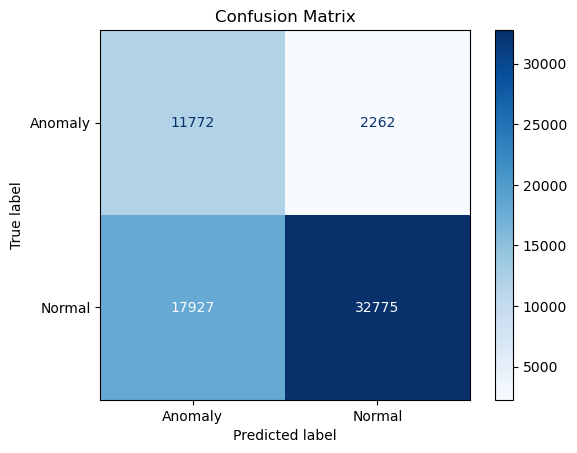

In [12]:
selected_features_with_label = selected_features.copy()
selected_features_with_label.append(label_column_name)
validate_model(model, benchmark, selected_features_with_label, label_column_name)
save_model_to_bucket(model, models_bucket_path)
